<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/pv_lstm_231117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import LSTM, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras import Model, Sequential
import json

In [ ]:
# 데이터 로딩
df = pd.read_excel('pvdata.xlsx')

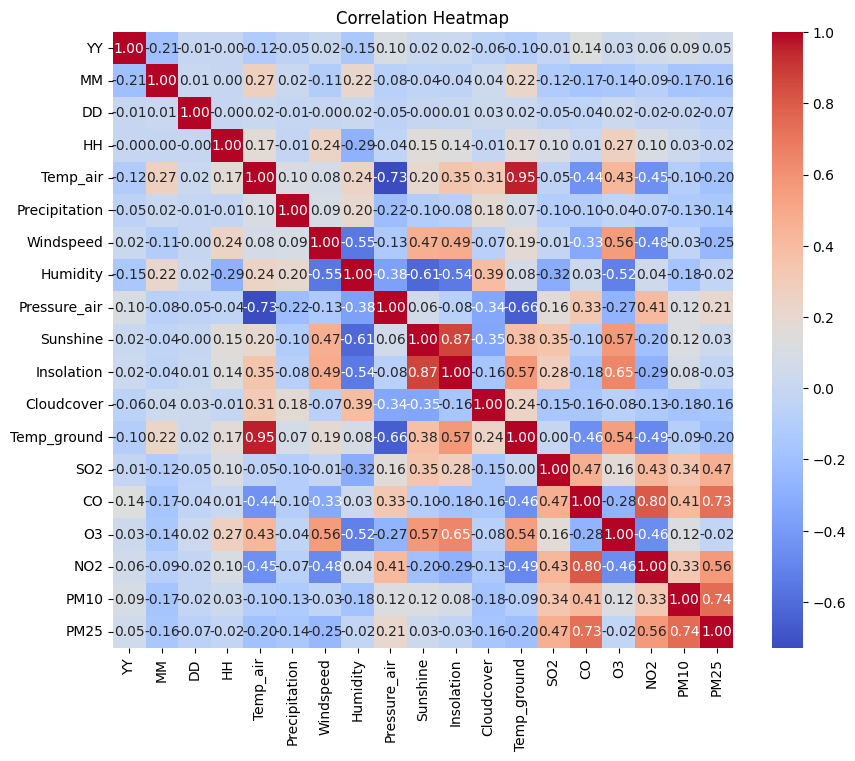

In [ ]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[(df['Date'] >= '2023-04-01') & (df['Date'] < '2023-05-01')]

In [ ]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.0001,0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'solarpower']), train['solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'solarpower']).columns[enet_train.coef_ != 0]
train = train[['Date', 'solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.0001
Selected features:  ['YY', 'MM', 'DD', 'HH', 'Temp_air', 'Precipitation', 'Windspeed', 'Humidity', 'Pressure_air', 'Sunshine', 'Insolation', 'Cloudcover', 'Temp_ground', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']


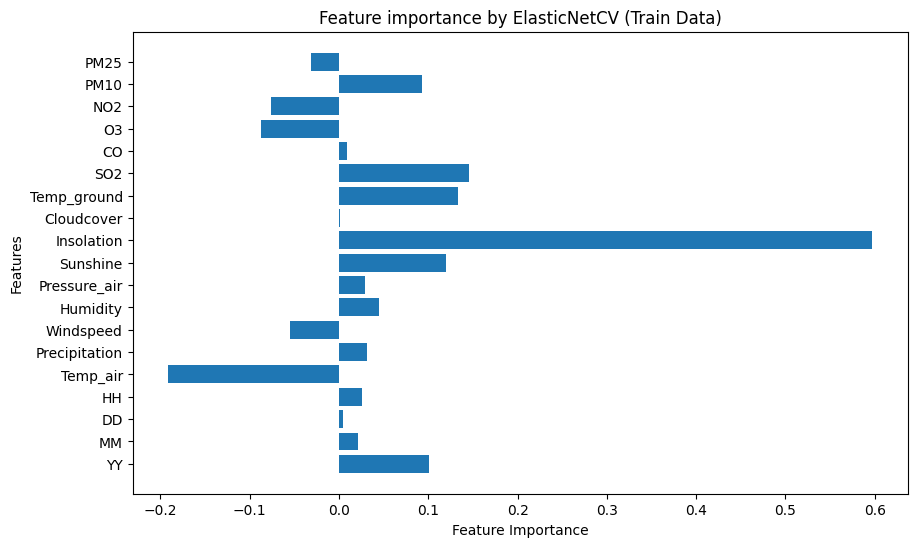

In [ ]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [ ]:
#3차원 데이터 만드는 함수
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [ ]:
train_np_x = train.drop(columns=['Date', 'solarpower']).to_numpy()
train_np_y = train["solarpower"].to_numpy()
test_np_x = test.drop(columns=['Date', 'solarpower']).to_numpy()
test_np_y = test["solarpower"].to_numpy()

In [ ]:
#3차원 변환
past_period = 72
future_target = 24
STEP = 1

x_train, y_train = multivariate_data(train_np_x, train_np_y, 0, None, past_period, future_target, STEP, single_step=True)

train_np_x.shape, x_train.shape

((28464, 19), (28368, 72, 19))

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().batch(BATCH_SIZE)